## Abstract
The data set TFI provides is peculiar in many aspects and we present more specific problems in
later sections. The TFI data set consists of a training and test set with 137 and 100,000 samples
respectively. This is interesting in itself since such a small training set is presented relative to
the final test set. The 137 training samples provide actual revenue while the test set does not and
expects the user to submit their predictions on the 100,000 firms. The 43 data fields provided are
listed below:
* ID: Restaurant ID
* Open Date: Date that the restaurant opened in the format M/D/Y
* City: The city name that the restaurant resides in
* City Group: The type of city can be either big cities or other
* Type: The type of the restaurant where FC - Food Court, IL - Inline, DT - Drive through and
MB - Mobile
* P-Variables (P1, P2, ... ,P37): Obfuscated variables within three categories: demographic
data, e.g population, age, gender; real estate data e.g car park availability and front facade;
commercial data e.g points of interest, other vendors, etc. It is unknown if each variable
contains a combination of the three categories or are mutually exclusive.
* Revenue: Annual (transformed) revenue of a restaurant in a given year and is the target to be
predicted
2
As shown, the majority of the data fields are obfuscated variables without giving the statistican
any prior knowledge of each one. One important rule overlooked in this competition is that no
additional third-party data may be added to the prediction. We believe this is done to ensure fairness
in access to information as well as to reward technical knowledge rather than business acumen.

The approaches used for this problem statement are as follows:
* Linear Regression
* Random Forest Regressor
* Support Vector Machine
* PCA(Principal Component Analysis)



## Import Libraries
It searches for the module initially in the local scope by calling import() function.
Libraries such as numpy, pandas, seaborn, matplotlib are used. The uses of the libraries is as follows:

numpy: It has a powerful N-Dimensional Array.It is a linear algebra library. It is mainly used for performing mathematical and logical operations. It provides features to perform operations on n-arrays and matrices in python.
Pandas: It is used for data munging. For preprocessing and cleaning data before use. It contains high-level data structures and manipulation tools designed to make data analysis fast and easy.
Seaborn: It is used for statistical data visualization. The pre-requisite for using seaborn is Matplotlib.
Matplotlib: Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
PyPlot is a module of matplotlib which is gives a MATLAB-like interface. It has plots like Image plot, Contour,Scatter, Polar, Line, 3-D plots etc.

In [2]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np 
import pandas as pd 

#reading the csv data
trainData = pd.read_csv('./train.csv')
trainData.info()

trainData.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
Id            137 non-null int64
Open Date     137 non-null object
City          137 non-null object
City Group    137 non-null object
Type          137 non-null object
P1            137 non-null int64
P2            137 non-null float64
P3            137 non-null float64
P4            137 non-null float64
P5            137 non-null int64
P6            137 non-null int64
P7            137 non-null int64
P8            137 non-null int64
P9            137 non-null int64
P10           137 non-null int64
P11           137 non-null int64
P12           137 non-null int64
P13           137 non-null float64
P14           137 non-null int64
P15           137 non-null int64
P16           137 non-null int64
P17           137 non-null int64
P18           137 non-null int64
P19           137 non-null int64
P20           137 non-null int64
P21           137 non-null int64
P22           137 non-nul

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


## PRE-PROCESSING & SOME ANALYSIS 
Converting Open Date column to Open Days; day count of the restaurant since the beginning and dropping the Open Date Columns

In [3]:
trainData['Open Date'] = pd.to_datetime(trainData['Open Date'], format='%m/%d/%Y')   
trainData['OpenDays']=""

dateLastTrain = pd.DataFrame({'Date':np.repeat(['01/01/2018'],[len(trainData)]) })
dateLastTrain['Date'] = pd.to_datetime(dateLastTrain['Date'], format='%m/%d/%Y')  

trainData['OpenDays'] = dateLastTrain['Date'] - trainData['Open Date']
trainData['OpenDays'] = trainData['OpenDays'].astype('timedelta64[D]').astype(int)

trainData = trainData.drop('Open Date', axis=1)

Comparing the revenues of big cities and other cities

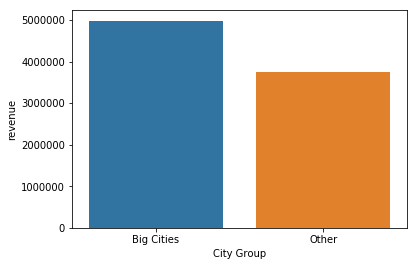

In [4]:
cityPerc = trainData[["City Group", "revenue"]].groupby(['City Group'],as_index=False).mean()

sns.barplot(x='City Group', y='revenue', data=cityPerc)

Sorting the cities by revenue; getting the max earned cities

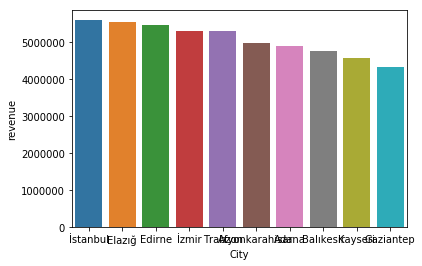

In [5]:
cityPerc = trainData[["City", "revenue"]].groupby(['City'],as_index=False).mean()

newDF = cityPerc.sort_values(["revenue"],ascending= False)
sns.barplot(x='City', y='revenue', data=newDF.head(10))

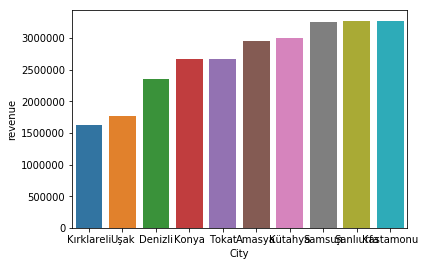

In [6]:
cityPerc = trainData[["City", "revenue"]].groupby(['City'],as_index=False).mean()
newDF = cityPerc.sort_values(["revenue"],ascending= True)
sns.barplot(x='City', y='revenue', data=newDF.head(10))

Getting an insight of which restaurant type earns more

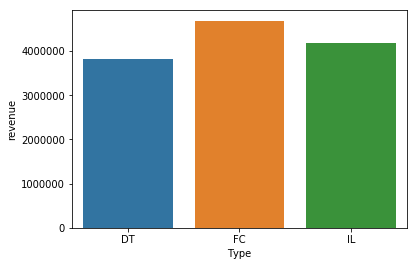

In [7]:
cityPerc = trainData[["Type", "revenue"]].groupby(['Type'],as_index=False).mean()
sns.barplot(x='Type', y='revenue', data=cityPerc)

Plot about working days of specific restaurant types

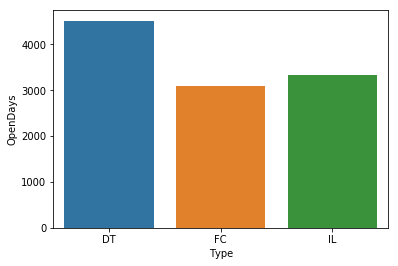

In [8]:
cityPerc = trainData[["Type", "OpenDays"]].groupby(['Type'],as_index=False).mean()
sns.barplot(x='Type', y='OpenDays', data=cityPerc)

Dropping the Id and Type columns since they are irrevelant for our predictions

In [9]:
trainData = trainData.drop('Id', axis=1)
trainData = trainData.drop('Type', axis=1)

Creating dummy variables to represent City Groups. After doing dummy variables for City Group we dropped it

In [10]:
citygroupDummy = pd.get_dummies(trainData['City Group'])
trainData = trainData.join(citygroupDummy)


trainData = trainData.drop('City Group', axis=1)

trainData = trainData.drop('City', axis=1)

tempRev = trainData['revenue']
trainData = trainData.drop('revenue', axis=1)


trainData = trainData.join(tempRev)


In [11]:
trainData.head(10)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P32,P33,P34,P35,P36,P37,OpenDays,Big Cities,Other,revenue
0,4,5.0,4.0,4.0,2,2,5,4,5,5,...,4,5,5,4,3,4,6743,1,0,5653753.0
1,4,5.0,4.0,4.0,1,2,5,5,5,5,...,0,0,0,0,0,0,3609,1,0,6923131.0
2,2,4.0,2.0,5.0,2,3,5,5,5,5,...,0,0,0,0,0,0,1759,0,1,2055379.0
3,6,4.5,6.0,6.0,4,4,10,8,10,10,...,10,6,18,12,12,6,2160,0,1,2675511.0
4,3,4.0,3.0,4.0,2,2,5,5,5,5,...,3,2,3,4,3,3,3159,0,1,4316715.0
5,6,6.0,4.5,7.5,8,10,10,8,8,8,...,0,0,0,0,0,0,2880,1,0,5017319.0
6,2,3.0,4.0,4.0,1,5,5,5,5,5,...,2,2,3,5,4,4,2639,1,0,5166635.0
7,4,5.0,4.0,5.0,2,3,5,4,4,4,...,0,0,0,0,0,0,2386,1,0,4491607.0
8,1,1.0,4.0,4.0,1,2,1,5,5,5,...,5,3,4,5,4,5,2683,0,1,4952497.0
9,6,4.5,6.0,7.5,6,4,10,10,10,10,...,0,0,0,0,0,0,2238,0,1,5444227.0


## Train and Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_trainData = ['P1','P2','P3','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37','OpenDays','Big Cities','Other','revenue']
X=trainData[['P1','P2','P3','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37','OpenDays','Big Cities','Other']]
y=trainData['revenue']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

## Random Forest 

In [16]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [17]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)

In [18]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 1630373.4452380952
Mean Squared Error: 4580420127423.028
Root Mean Squared Error: 2140191.6099786554


## Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
print(regressor.intercept_)  

4526096.610526317


In [21]:
print(regressor.coef_)  

[  943767.11350095    45530.73092479  -252277.37513778  -287597.85194633
   301537.98407122   369077.91840554 -3091284.53319765  2468397.26652832
  2371709.37623301  -809778.51817724   613673.42735011 -2471676.98855781
   283583.52533248 -1283461.92824511  -854837.62243185  1831204.63789947
  -727042.31389644  -913264.80423887 -1640900.48112114   729751.51194912
  -537119.09992065   708015.78083969  3821017.30428549   601102.16864924
 -5478365.70843341  -477787.72485387   959137.96010506  -136574.00331294
  -859740.55216512   978608.22667444 -2673965.81260769 -1314093.83469966
  3283572.29558073 -1572094.78130015  3287058.2668472    754464.85145165
  1080750.63540794   463016.29284839  -463016.2928484 ]


In [22]:
y_pred = regressor.predict(X_test)  

In [23]:
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 3046129.6556894397
Mean Squared Error: 17990595279476.082
Root Mean Squared Error: 4241532.18536369


## SVM

In [24]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
y_pred = svclassifier.predict(X_test) 

In [26]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
             precision    recall  f1-score   support

  1149870.0       0.00      0.00      0.00         0
  1270499.0       0.00      0.00      0.00         0
  1734634.0       0.00      0.00      0.00         1
  1756069.0       0.00      0.00      0.00         1
  2021934.0       0.00      0.00      0.00         1
  2025297.0       0.00      0.00      0.00         0
  2156098.0       0.00      0.00      0.00         1
  2267425.0       0.00      0.00      0.00         0
  2364478.0       0.00      0.00      0.00         1
  2383840.0       0.00      0.00      0.00         1
  2390534.0       0.00      0.00      0.00         1
  2551252.0       0.00      0.00      0.00         1
  2740687.0       0.00      0.00      0.00         1
  2999068.0       0.00      0.00      0.00         0
  3004429.0       0.00      0.00      0.00         0
  3028267.0       0.00      0.0

C:\Users\sayal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sayal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## PCA

In [28]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_std  = True ,with_mean = True, copy = True)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [29]:
X_train_std[:1]

array([[-0.38495478, -0.26878835, -0.40218579, -0.86831345, -0.60640228,
        -0.21197477, -0.09193085, -0.28367811, -0.32805993, -0.72239946,
        -0.20493853, -0.17688954, -0.53558621, -0.55482387, -0.53909668,
        -0.54319176, -0.56469648, -0.56773892, -0.42289157, -0.64846424,
        -0.23138702, -0.55058901, -0.5758169 , -0.55122535, -0.54928691,
        -0.55868973, -0.58934104, -0.65533505, -0.47551635, -0.55720244,
        -0.49633189, -0.62710185, -0.46694641, -0.56766874, -0.51840251,
        -0.59245005,  0.71618149, -1.09968283,  1.09968283]])

In [30]:
from sklearn.decomposition import PCA,KernelPCA

pca = PCA(n_components=2,svd_solver='full')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
pca.explained_variance_ratio_

kpca = KernelPCA(kernel="rbf", gamma=1)
X_kpca_train = kpca.fit_transform(X_train_pca)
X_kpca_test = kpca.transform(X_test_pca)

Text(0.5,0,'After RBF')

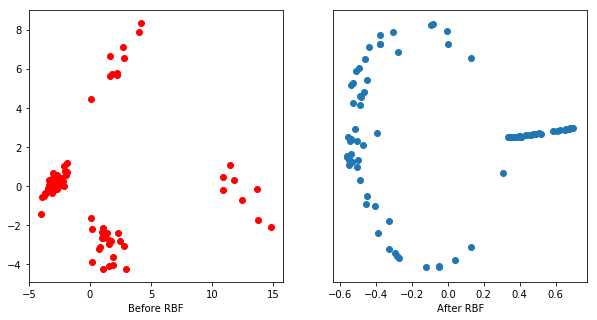

In [31]:
X_train_pca[:1]
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1],color='red',marker='o')
ax[1].scatter(X_kpca_train[:, 0], X_kpca_train[:, 1])
ax[0].set_xlabel('Before RBF')
ax[1].set_yticks([])
ax[1].set_xlabel('After RBF')

## Hyper Parameter Tuning for Random Forest 

### Random Search Cross Validation in Scikit-Learn

#### To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:

In [33]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [10, 57, 105, 152, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, None], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 4]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 5X 2X 2X 2X 5 = 400 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values

In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.7s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 57, 105, 152, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, None], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively).

More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time

In [35]:
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10}

## Evaluate Random Search

To determine if random search yielded a better model, we compare the base model with the best random search model.

In [54]:
def evaluate_reg(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_reg(base_model, X_test, y_test)

Model Performance
Average Error: 1771728.3738 degrees.
Accuracy = 55.00%.


## Grid Search with Cross Validation

Grid Search with Cross Validation we use every combination for much better results for developing the model To use Grid Search, we make another grid based on the best values provided by random search

In [55]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None],
    'max_features': [2, 3],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [3,5,7],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [56]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   38.3s finished


{'bootstrap': True,
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 100}

In [57]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate_reg(best_grid, X_test, y_test)

Model Performance
Average Error: 1297256.8026 degrees.
Accuracy = 61.55%.


In [58]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 11.90%.


## Consclusion

After Comparing all the algorithms 
* Random Forest - 214019.6
* Linear Regression - 4241532.1
Since Random forest has given the best score for RMSE it is considered to be the best model as compared to linear regression.
* Random forest works the best on our pre-processed data
* Since the training data set is very small and we have to make the best out of what is available we did a lot of data pre-processing.
* We coverted all the categorical data into numeric.
* Since our dataset contains lots of attributes to consider for prediction we built the model with it.
* Pre processing of data is very important and it improved our RMSE scores drastically.

## Contribution

* Preprocessing of the data (data clean)
* Explained the given code with Insights and results
* Implemented Linear Regression,Random Forest and SVM
* Performed HyperParameter Tuning on Random Forest(Best model)
* The code was implemented by research on different websites 

## Citations

* http://kpei.me/blog/wp-content/uploads/2015/05/TFIKaggleReport.pdf --Research paper
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html --Random Forest
* https://www.kaggle.com/c/restaurant-revenue-prediction -- Dataset from kaggle
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html --SVM
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html --Linear Regression
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 --Hyper Parameter tuning

## Licence

Must have a license such as the MIT License https://opensource.org/licenses/MIT
Copyright

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
By Spurthi Shetty & Sayali Borse.